$$
\begin{aligned}
a_{i} &= f(x_{:i}) \\
a_{i} &= f(v_{:i}) \\
\end{aligned}
$$

In [3]:
import sys
sys.path.append('..')
from LATMOS import *

from utils import *
from solver import *

from collections import defaultdict

import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import torchvision
import random

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32 #torch.bfloat16
print(f"Using: {device}, {dtype}")

In [5]:
def get_image_embeddings(images, batch_size=32):
    """
    Generate embeddings for a batch of images using ResNet50
    
    Args:
        images (np.ndarray): Batch of images with shape [total_images, 256, 256, 3]
        batch_size (int): Size of mini-batches to process at once
        device (str): Device to run the model on ('cuda' or 'cpu')
    
    Returns:
        torch.Tensor: Image embeddings with shape [total_images, 2048]
    """
    # Load pretrained ResNet50 model
    vision_model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
    # Remove the final classification layer
    vision_model = torch.nn.Sequential(*list(vision_model.children())[:-1])
    vision_model = vision_model.to(device)
    vision_model.eval()
    
    # Define image preprocessing
    preprocess = torchvision.transforms.Compose([
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    total_images = len(images)
    all_embeddings = []
    
    # Process images in batches
    for i in range(0, total_images, batch_size):
        batch_end = min(i + batch_size, total_images)
        batch_images = images[i:batch_end]
        
        # Convert numpy array to torch tensor and move to device
        # Assuming images are in range [0, 1]
        batch_tensor = torch.from_numpy(batch_images).to(dtype).to(device)
        # Convert from [batch_size, height, width, channels] to [batch_size, channels, height, width]
        batch_tensor = batch_tensor.permute(0, 3, 1, 2)
        
        # Preprocess images
        batch_tensor = preprocess(batch_tensor)

        # Generate embeddings
        with torch.no_grad():
            batch_embeddings = vision_model(batch_tensor)
            
        # Reshape from [batch_size, 2048, 1, 1] to [batch_size, 2048]
        batch_embeddings = batch_embeddings.squeeze(-1).squeeze(-1)
        
        all_embeddings.append(batch_embeddings)
        
        # Clear CUDA cache if needed
        if device == 'cuda':
            torch.cuda.empty_cache()
    
    # Concatenate all batches
    final_embeddings = torch.cat(all_embeddings, dim=0)
    return final_embeddings

In [6]:
solver = DoorKeySolver_2() 
solver.solve()

# state_space = list(solver.iter_state_space())
# state_vec_space = torch.stack([state.to_vec() for state in state_space]).to(device)
# state_img_space = np.array([state.render() for state in state_space])
# state_emb_space = get_image_embeddings(state_img_space)

# state_data = {
#     'state_space': state_space,
#     'state_vec_space': state_vec_space,
#     # 'state_img_space': state_img_space,
#     'state_emb_space': state_emb_space
# }
# torch.save(state_data, 'state_data')

state_data = torch.load('state_data', map_location = 'cpu', weights_only=False)
state_space = state_data['state_space']
state_vec_space = state_data['state_vec_space']
state_emb_space = state_data['state_emb_space']

state_img_space = torch.stack([state.abs_render() for state in state_space])

In [7]:
def gen_policy_mapping(solver, state_space):
    # Create a mapping from state to index
    state_to_idx = {state: idx for idx, state in enumerate(state_space)}
    
    t0 = min(solver.Pi_t.keys())
    leaf_indices = set(range(len(state_space)))
    best_mapping = {}  # Will store index -> index
    next_mapping = {}  # Will store index -> list of indices
    
    for state_idx, state in enumerate(state_space):
        next_indices = []
        for control in solver.iter_control_space():
            next_state, _ = solver.motion_model(state, control)
            if next_state is None:
                continue
                
            # Only process if next_state is in our state space
            if next_state in state_to_idx:
                next_state_idx = state_to_idx[next_state]
                
                if control == solver.Pi_t[t0][state]:
                    best_mapping[state_idx] = next_state_idx
                    if next_state_idx in leaf_indices:
                        leaf_indices.remove(next_state_idx)
                else:
                    next_indices.append(next_state_idx)

        if next_indices:
            next_mapping[state_idx] = next_indices
            
    return best_mapping, next_mapping, sorted(leaf_indices), state_to_idx

def gen_data_all(state_indices, best_mapping, next_mapping, input_space):
    state_data = []
    accpt_data = []
    
    for start_idx in tqdm(state_indices):
        pos_idx_seq = []
        pos_accpt_seq = []
        neg_idx_seqs = []
        neg_accpt_seqs = []
        
        curr_idx = start_idx
        while curr_idx != best_mapping[curr_idx]:
            # next_idx = curr_idx
            # From current non-opt state move forward 10 steps
            pos_idx_seq.append(curr_idx)
            pos_accpt_seq.append(1)
            for next_idx in next_mapping[curr_idx]:
                # Augment by sub-opt next states
                neg_idx_seq = pos_idx_seq.copy()
                neg_accpt_seq = pos_accpt_seq.copy()
                # Alternative augmentations:
                # next_idx = best_mapping[next_idx]  # augment by opt next states
                # next_idx = random.choice(state_indices)  # augment by random next states
                neg_idx_seq.append(next_idx)
                neg_accpt_seq.append(0)
                for _ in range(2):
                    next_idx = random.choice(next_mapping[next_idx])
                    neg_idx_seq.append(next_idx)
                    neg_accpt_seq.append(0)
                neg_idx_seqs.append(neg_idx_seq)
                neg_accpt_seqs.append(neg_accpt_seq)

            curr_idx = best_mapping[curr_idx]

        pos_idx_seq.append(curr_idx)
        pos_accpt_seq.append(1)
        for next_idx in next_mapping[curr_idx]:
            # Augment by sub-opt next states
            neg_idx_seq = pos_idx_seq.copy()
            neg_accpt_seq = pos_accpt_seq.copy()
            # Alternative augmentations:
            # next_idx = best_mapping[next_idx]  # augment by opt next states
            # next_idx = random.choice(state_indices)  # augment by random next states
            neg_idx_seq.append(next_idx)
            neg_accpt_seq.append(0)
            neg_idx_seqs.append(neg_idx_seq)
            neg_accpt_seqs.append(neg_accpt_seq)
        
        # Convert sequences to integer tensors
        pos_idx_seq = torch.tensor(pos_idx_seq, dtype=torch.int32)
        pos_accpt_seq = torch.tensor(pos_accpt_seq, dtype=torch.int32)
        
        neg_idx_seqs = [torch.tensor(seq, dtype=torch.int32) for seq in neg_idx_seqs]
        neg_accpt_seqs = [torch.tensor(seq, dtype=torch.int32) for seq in neg_accpt_seqs]
        
        state_data = state_data + [pos_idx_seq] + neg_idx_seqs
        accpt_data = accpt_data + [pos_accpt_seq] + neg_accpt_seqs
    
    return [input_space[x] for x in state_data], accpt_data

def batch_by_length(data):
    """
    data: list of (seq_len, state_dim) tensors
    return list of batches of (batch_size, seq_len, state_dim) tensors
    """
    re = defaultdict(list)
    for seq in data:
        if seq.shape[0] > 2:
            re[seq.shape[0]].append(seq)
    
    for k, v in re.items():
        re[k] = torch.stack(v).to(device)
    
    return list(re.values())

In [8]:
best_mapping, next_mapping, leaf_states, state_to_idx = gen_policy_mapping(solver, state_space)

# Choose which state representation to use
input_space = state_img_space.to(device)
# input_space = state_vec_space

In [ ]:
input_space.shape

In [ ]:
state_data, accpt_data = gen_data_all(leaf_states, best_mapping, next_mapping, input_space)
state_data_torch = batch_by_length(state_data)
accpt_data_torch = batch_by_length(accpt_data)

---

In [11]:
def train_model_doorkey(encoder, model, best_mapping, next_mapping, input_space,
                        epochs, learning_rate, patience):  # Added use_embedding flag
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(list(encoder.parameters()) + list(model.parameters()), lr=learning_rate)
    scheduler = CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-5)

    # Early stopping variables
    best_loss = float('inf')
    patience_counter = 0
    
    # Metrics recording
    train_loss_history = []
    train_metrics_history = []
    
    # state_data, accpt_data = gen_data_all(leaf_states, best_mapping, next_mapping, input_space)
    # state_data_torch = batch_by_length(state_data)
    # accpt_data_torch = batch_by_length(accpt_data)
    # paired_data = list(zip(accpt_data_torch, state_data_torch))

    bar = tqdm(range(epochs))
    for epoch in bar:
        total_loss = 0
        acceptance_TP, acceptance_TN, acceptance_FP, acceptance_FN = 0, 0, 0, 0
        total_steps = 0

        if (epoch%50) == 0:
            print('sample new')
            # state_data, accpt_data = gen_data_all(random.sample(leaf_states, 1000), best_mapping, next_mapping, input_space)
            state_data, accpt_data = gen_data_all(random.sample(sorted(best_mapping.keys()), 5000), best_mapping, next_mapping, input_space)
            state_data_torch = batch_by_length(state_data)
            accpt_data_torch = batch_by_length(accpt_data)
            paired_data = list(zip(accpt_data_torch, state_data_torch))
        model.train()
        
        random.shuffle(paired_data)
        for batch_acceptance, batch_state in paired_data:
            optimizer.zero_grad()
            # Forward pass
            batch_embedding = encoder(batch_state)
            state_output, acceptance_output = model(batch_embedding)

            # Flatten acceptance output and target
            acceptance_output_flat = acceptance_output.view(-1, 2)
            batch_acceptance_flat = batch_acceptance.view(-1).to(torch.long)
            
            # Compute losses
            acceptance_loss = criterion(acceptance_output_flat, batch_acceptance_flat)
            loss = acceptance_loss
            
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            # Calculate acceptance accuracy
            predicted_acceptance = acceptance_output.argmax(dim=-1).bool()
            batch_acceptance = batch_acceptance.bool() if batch_acceptance.dtype != torch.bool else batch_acceptance
            acceptance_TP += ( predicted_acceptance &  batch_acceptance).sum().item()
            acceptance_TN += (~predicted_acceptance & ~batch_acceptance).sum().item()
            acceptance_FP += ( predicted_acceptance & ~batch_acceptance).sum().item()
            acceptance_FN += (~predicted_acceptance &  batch_acceptance).sum().item()
            total_steps += batch_acceptance.size(0) * batch_acceptance.size(1)
            
            del batch_acceptance, batch_state
        
        scheduler.step()
        train_loss_history.append(total_loss / total_steps)
        train_metrics_history.append({
            'TP': acceptance_TP / total_steps,
            'TN': acceptance_TN / total_steps,
            'FP': acceptance_FP / total_steps,
            'FN': acceptance_FN / total_steps
        })
        
        # Early stopping check
        if total_loss < best_loss:
            best_loss = total_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\nEarly stopping triggered after {epoch + 1} epochs")
                break
                
        bar.set_postfix({
            'Average Loss': total_loss / total_steps,
            'accuracy': (acceptance_TP + acceptance_TN) / total_steps,
            'train_acceptance_TP': acceptance_TP / total_steps,
            'train_acceptance_TN': acceptance_TN / total_steps,
            'train_acceptance_FP': acceptance_FP / total_steps,
            'train_acceptance_FN': acceptance_FN / total_steps
        })
    
    return train_loss_history, train_metrics_history

In [ ]:
class ImageEmbedder(nn.Module):
    """
    CNN module
    """
    def __init__(self, in_channels, out_channels):
        super(ImageEmbedder, self).__init__()

        self.MLP = nn.Sequential(
            nn.Linear(in_channels, (in_channels+out_channels) // 2),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear((in_channels+out_channels) // 2, out_channels),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
        )

        # First convolutional layer
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(16)
        
        # Global pooling and final projection to embedding dimension
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(32, 5)
    
    def forward(self, x):
        """
        Forward pass for a single image.
        
        Args:
            x: Input tensor of shape (batch_size, 3, 8, 8)
            
        Returns:
            Embedding tensor of shape (batch_size, 5)
        """
        batch_size, seq_len, height, width, channels = x.shape

        # x = x.view(batch_size*seq_len, height*width*channels)
        # x = self.MLP(x)
        # return x.view(batch_size, seq_len, -1)

        x = x.view(-1, channels, height, width)

        # First conv block
        x = self.conv(x)
        x = self.bn(x)
        x = torch.relu(x)
        
        # Global pooling and projection
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)  # Flatten: (batch_size, 32)
        x = self.fc(x)             # Project: (batch_size, 5)
        
        return x.view(batch_size, seq_len, -1)

In [ ]:
num_channels = 8*8*5
encoder = ImageEmbedder(8*8*9, 8*8*5).to(device)
seq_model = create_model('gru',
                     input_size  = 8*8*5, 
                     hidden_size = 512,
                     output_size = 1,
                     device=device)
seq_model.get_model_size()

In [14]:
# # Train the model
# losses = train_model_doorkey(encoder, seq_model, best_mapping, next_mapping, input_space,
#                              epochs=50, learning_rate=1e-3, patience=40)

In [ ]:
# # Save both models to the same file
# checkpoint = {
#     'seq_model': seq_model.state_dict(),
#     'encoder': encoder.state_dict()
# }
# torch.save(checkpoint, 'gru_1.pth')

# Load both models from the file
checkpoint = torch.load('gru_1.pth')
seq_model.load_state_dict(checkpoint['seq_model'])
encoder.load_state_dict(checkpoint['encoder'])

# Move models to device
seq_model = seq_model.to(device)
encoder = encoder.to(device)

---
planning inference w/ A*

In [16]:
import copy
feasible_mapping = copy.deepcopy(next_mapping)
for key in feasible_mapping:
    feasible_mapping[key].append(best_mapping[key])

In [17]:
from queue import PriorityQueue
from typing import Dict, List, Callable, Tuple, Optional, Set

def a_star_search(
    start_idx: int,
    goal_idx: int,
    feasible_states_map: Dict[int, List[int]],
    heuristic_fn: Callable[[List[int], int], float],
    cost_fn: Callable[[int, int], float] = lambda x, y: 1.0
) -> Tuple[List[int], float, int, Dict, Set]:
    """
    Implements A* search algorithm over a state space model with path-aware heuristic,
    using state indices instead of state objects.
    
    Args:
        start_idx: Index of initial state
        goal_idx: Index of target state to reach
        feasible_states_map: Dictionary mapping state indices to their possible next state indices
        heuristic_fn: Function taking (path_of_indices, goal_idx) and returning estimated cost
        cost_fn: Function taking (current_idx, next_idx) and returning transition cost
    
    Returns:
        Tuple containing:
        - List of state indices forming the path from start to goal
        - Total cost of the path
        - Number of states explored/generated during search
    """
    frontier = PriorityQueue()
    frontier.put((0, start_idx))
    
    came_from = {start_idx: None}
    g_score = {start_idx: 0}
    
    # Calculate initial f_score using the full path context
    initial_path = [start_idx]
    f_score = {start_idx: heuristic_fn(initial_path, goal_idx)}
    
    explored = set()
    explored_count = 0
    
    while not frontier.empty():
        current_f, current_idx = frontier.get()
        
        if current_idx == goal_idx:
            # Goal found, reconstruct path
            final_path = reconstruct_path(came_from, current_idx)
            return final_path, g_score[goal_idx], explored_count, came_from, explored
        
        explored.add(current_idx)
        explored_count += 1
        
        # Get the path from start to current state
        current_path = reconstruct_path(came_from, current_idx)
        
        # Explore neighbors
        for next_idx in feasible_states_map.get(current_idx, []):
            if next_idx in explored:
                continue
                
            tentative_g = g_score[current_idx] + cost_fn(current_idx, next_idx)
            
            if next_idx not in g_score or tentative_g < g_score[next_idx]:
                came_from[next_idx] = current_idx
                g_score[next_idx] = tentative_g
                
                # Calculate f-score using the full path to next_state
                next_path = current_path + [next_idx]
                f = tentative_g + heuristic_fn(next_path, goal_idx)
                f_score[next_idx] = f
                frontier.put((f, next_idx))
                
                # Count newly generated states
                if next_idx not in g_score:
                    explored_count += 1
    
    return None, float('inf'), explored_count, came_from, explored

def reconstruct_path(came_from: Dict[int, Optional[int]], current_idx: int) -> List[int]:
    """
    Reconstructs the path from start to current state using the came_from mapping.
    
    Args:
        came_from: Dictionary mapping state indices to their predecessor indices
        current_idx: Index of the current state
    
    Returns:
        List of state indices representing the path from start to current state
    """
    path = [current_idx]
    while came_from[current_idx] is not None:
        current_idx = came_from[current_idx]
        path.append(current_idx)
    return list(reversed(path))

In [18]:
hidden_state_map = {}
def model_heuristic(path: List[int], goal:int):
    encoder.eval()
    seq_model.eval()
    path_len = len(path)
    path_input = input_space[path].unsqueeze(0)
    batch_embedding = encoder(path_input)
    state_output, acceptance_output = seq_model(batch_embedding)
    acceptance_prob = torch.softmax(acceptance_output[0, -1, :], dim =-1)[1]
    hidden_state_map[path[-1]] = batch_embedding[0, -1].flatten()
    return - len(path)*1.01 - acceptance_prob
def model_l2_heuristic(path: List[int], goal:int):
    path_input = input_space[path[-1]].unsqueeze(0).unsqueeze(0)
    state_embeds = encoder(path_input).squeeze().squeeze()
    # print(state_embeds.shape)
    goal_input = input_space[goal].unsqueeze(0).unsqueeze(0)
    goal_embeds = encoder(goal_input).squeeze().squeeze()
    # print(goal_embeds.shape)
    return torch.norm(goal_embeds - state_embeds, p=2, dim=0).item()
def dijkstra_heuristic(path: List[int], goal: int) -> float:
    """Simple example heuristic - just returns 1 if not goal, 0 if goal"""
    # path_input = input_space[path].unsqueeze(0)
    # _, hidden_states = seq_model.encoder(seq_model.input_embedder(path_input))
    # print(len(path), hidden_states.shape)
    # hidden_state_map[path[-1]] = hidden_states.detach().flatten()
    return 0
def l2_heuristic(path: List[int], goal: int) -> float:
    state = input_space[path[-1]]
    goal = input_space[goal]
    return torch.norm(goal - state, p=2, dim=0).item()

In [24]:
test_start_idx = 702
test_start_state = leaf_states[test_start_idx]

goal_idx = best_mapping[test_start_idx]
while best_mapping[goal_idx] != goal_idx:
    goal_idx = best_mapping[goal_idx]
goal_state = state_space[goal_idx]

path, cost, explored_count, came_from, explored = a_star_search(test_start_idx, goal_idx, feasible_mapping, model_heuristic)
cost, explored_count, len(came_from), len(explored)

(12.0, 12, 33, 12)

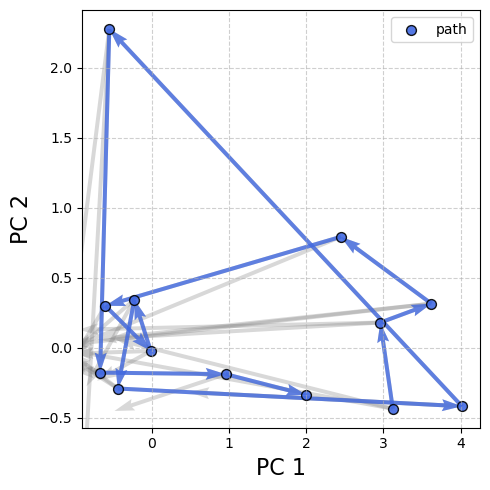

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Convert to NumPy for PCA

# Apply PCA
pca = PCA(n_components=2)
VPCA = False

if VPCA:
    # vision
    pca.fit(input_space[list(came_from.keys())].cpu().numpy())
    # pca.fit(input_space[path].cpu().numpy())
    projected_path = pca.transform(input_space[path].cpu().numpy())
else:
    # h space
    pca.fit(torch.stack([hidden_state_map[k] for k in came_from.keys()]).detach().cpu().numpy())
    projected_path = pca.transform(torch.stack([hidden_state_map[k] for k in path]).detach().cpu().numpy())

# Create figure
plt.figure(figsize=(5, 5))

# Plot arrows (edges) with precise end positioning
for k, v in came_from.items():
    if (v is None) :
    # or (k not in explored):
        continue
    if VPCA:
        kv = pca.transform(input_space[[k,v]].cpu().numpy())
    else:
        kv = pca.transform(torch.stack([hidden_state_map[k], hidden_state_map[v]]).detach().cpu().numpy())

    # Calculate direction vectors for arrows
    dx, dy = kv[0, 0] - kv[1, 0], kv[0, 1] - kv[1, 1]
    
    # Use quiver for precise placement
    plt.quiver(kv[1, 0], kv[1, 1], dx, dy, 
               angles='xy', scale_units='xy', scale=1, 
               color='gray', alpha=0.3, linewidth=1.5, width=0.01, headwidth=3)

    # Mark start & end nodes distinctly
    # plt.scatter(kv[:, 0], kv[:, 1], color='red', s=80, edgecolors='black', alpha=0.9)
    
# Plot arrows (edges) for the path
for i in range(len(projected_path) - 1):
    x_start, y_start = projected_path[i]
    x_end, y_end = projected_path[i + 1]
    
    dx, dy = x_end - x_start, y_end - y_start  # Direction vector
    
    # Use quiver to draw the path with precise placement
    plt.quiver(x_start, y_start, dx, dy, 
               angles='xy', scale_units='xy', scale=1, 
               color='royalblue', alpha=0.8, linewidth=1.5, width=0.01, headwidth=3)

# Scatter plot of path points
plt.scatter(projected_path[:, 0], projected_path[:, 1], 
            color='royalblue', edgecolors='black', 
            s=50, alpha=0.9, label="path")

# Annotate points for clarity
# for i, (x, y) in enumerate(projected_data):
#     plt.text(x + 0.02, y + 0.02, str(i), fontsize=12, color='black', ha='right')

# Plot enhancements
plt.xlabel("PC 1", fontsize=16)
plt.ylabel("PC 2", fontsize=16)
# plt.title("PCA Projection of Tree Structure", fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

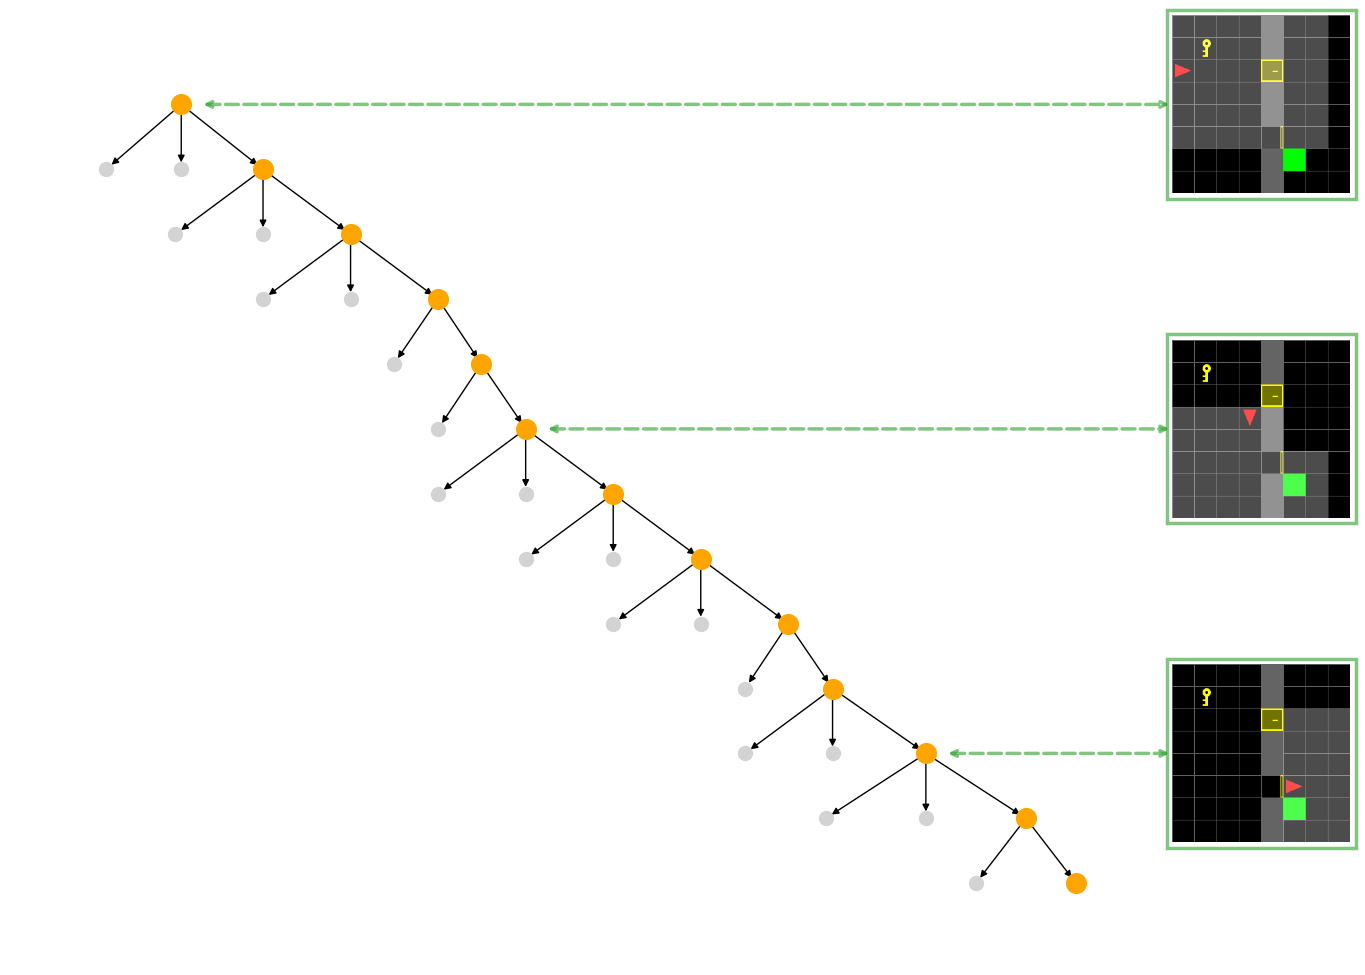

In [26]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np

def visualize_graph_with_states(graph_dict, path, explored, state_space, key_indices=[]):
    # Create a directed graph
    G = nx.DiGraph()
    
    # Add edges from dictionary
    for node, neighbor in graph_dict.items():
        if (neighbor is None):
            continue
        G.add_edge(neighbor, node)
    
    # Create figure and axes
    fig = plt.figure(figsize=(14, 10))
    ax_graph = fig.add_subplot(111)
    
    # Use Graphviz layout for left-to-right orientation
    pos = nx.nx_agraph.graphviz_layout(G, prog="dot")
    
    # Draw the base graph
    nx.draw(G, pos, with_labels=False, node_color='lightgray', edge_color='black', linewidths=1, node_size=100, ax=ax_graph)

    # Highlight the explored nodes
    nx.draw_networkx_nodes(G, pos, nodelist=explored, node_color='pink', node_size=100, ax=ax_graph)
    
    # Highlight the path
    nx.draw_networkx_nodes(G, pos, nodelist=path, node_color='orange', node_size=200, ax=ax_graph)
    
    # Calculate the right edge of the graph
    right_edge = max(x for x, y in pos.values()) + 100  # Add some padding
    
    # Add state visualizations for key points in the path
    for i, idx in enumerate(key_indices):
        node_id = path[idx]  # Get the actual node ID from the path
        
        # Check if node_id exists in pos dictionary
        if node_id not in pos:
            print(f"Warning: Node {node_id} not found in graph positions")
            continue
            
        # Get the node's x and y coordinates
        node_x, node_y = pos[node_id]
        
        # Get state using the node ID
        state = state_space[node_id]  
        img = state.render()  # Get the 256x256 image
        
        # Create an OffsetImage from the state's rendered image
        imagebox = OffsetImage(img, zoom=0.5)  # Adjust zoom factor as needed
        
        # Place annotation box at the right edge aligned with the node's y-coordinate
        ab = AnnotationBbox(
            imagebox, 
            (right_edge, node_y),  # Place on right edge at same y-level as node
            frameon=True,          # Show a frame around the image
            box_alignment=(0, 0.5),  # Center align vertically
            bboxprops=dict(edgecolor='C2', linewidth=2.5, alpha=0.6)
        )
        
        # Add the annotation box to the axes
        ax_graph.add_artist(ab)
        
        # Add a line connecting the node to its state visualization
        # ax_graph.plot(
        #     [node_x, right_edge],  # Subtract half the image width (256*0.5*0.5)
        #     [node_y, node_y], 
        #     '--', 
        #     color='grey',
        #     alpha=0.6,
        #     linewidth=2.5
        # )
        ax_graph.annotate("",  # Empty text
            xy=(right_edge, node_y),  # End point (arrow head)
            xytext=(node_x+20, node_y),  # Start point (arrow tail)
            arrowprops=dict(
                arrowstyle="<->",
                linestyle="--",
                color="C2",
                alpha=0.6,
                linewidth=2.5  # Control the arrow line thickness
            )
        )
        # Add state index label
        # ax_graph.text(
        #     right_edge,
        #     node_y + 130,  # Place text above the image
        #     f"State {state.__hash__()}",
        #     ha='left',
        #     bbox=dict(boxstyle="round,pad=0.3", fc="yellow", alpha=0.7)
        # )
    
    # Set axis limits to include the right edge with images
    ax_graph.set_xlim(
        min(x for x, y in pos.values()) - 100,
        right_edge + 150
    )
    
    plt.tight_layout()
    plt.show()

# Example usage
visualize_graph_with_states(came_from, path, explored, state_space, [0, 5, 10])

---
optimized generation

In [ ]:
def optimized_generation(model, x0, max_length,
                         lr = 0.01, num_iterations_per_step = 500, threshold = 1e-2):
    """
    Generates a sequence by iteratively optimizing each input to maximize the model's output.

    Args:
        model: A function or PyTorch module that takes a sequence of inputs of shape (seq_length, state_dim)
               and returns a scalar output.
        x0: A tensor of shape (1, state_dim), representing the initial input.
        max_length: An integer specifying the desired length of the output sequence.

    Returns:
        A tensor of shape (max_length, state_dim), representing the optimized sequence.
    """
    # Ensure x0 requires no gradients and is detached from any computational graph
    state_dim = x0.shape[1]
    # Example mask where True indicates components to optimize
    optimize_mask = torch.tensor([True, True, True, True, 
                                  False, False, 
                                  False, False, True,
                                  False, False, True,
                                  False, False, True])  # Adjust based on state_dim

    x_fixed = [x0.detach()]
    sequence = [x0.detach()]
    xi_prev = x0.detach()  # Start xi_prev as x0
    
    seq_losses = []
    for _ in tqdm(range(1, max_length)):
        xi_initial = xi_prev.clone().detach().requires_grad_(True)
        xi_fixed = xi_initial.clone().detach()
        xi_fixed[:, optimize_mask] = 0  # Zero out variable positions

        # Variable components to optimize
        xi_var_initial = xi_initial[:, optimize_mask].clone().detach().requires_grad_(True)
        optimizer = torch.optim.Adam([xi_var_initial], lr=lr)

        step_losses = []

        for _ in range(num_iterations_per_step):
            optimizer.zero_grad()

            xi_variable = torch.zeros_like(xi_fixed)
            xi_variable[:, optimize_mask] = xi_var_initial
            xi = xi_fixed + xi_variable

            x_fixed_detached = [x.detach() for x in x_fixed]  # Detach previous inputs
            x_seq = torch.cat(x_fixed_detached + [xi], dim=0).unsqueeze(0)  # (1, seq_length, state_dim)

            # Compute the model's output
            state_output, acceptance_output = model(x_seq) # (1, seq_length, 1)

            # Since we want to maximize y, we minimize -y
            loss = 1 - acceptance_output[0,-1,0]
            loss.backward()

            # Perform a gradient ascent step on xi
            optimizer.step()

            if loss.item() < threshold:
                print("early break by the threshold")
                break
            step_losses.append(loss.item())

        # Detach xi to prevent further gradient tracking
        xi_optimized = xi.detach()
        xi_prev = xi_optimized  # Update xi_prev for next iteration
        x_fixed.append(xi_optimized)
        sequence.append(xi_optimized)
        seq_losses.append(step_losses)

    step_sum = 0
    for i, step_losses in enumerate(seq_losses):
        plt.plot(np.arange(step_sum, step_sum+len(step_losses)), step_losses, label=f'Step {i}')
        step_sum += len(step_losses)
    plt.show()

    return sequence

gen_sequence = optimized_generation(vision_model, test_start_state.to_vec().to(device).to(torch.float).unsqueeze(0), 10)
gen_sequence_state = [State(2).from_vec(vec.squeeze()) for vec in gen_sequence]

In [ ]:
with imageio.get_writer(f'plan_trace_all.gif', mode="I", duration=0.1*len(gen_sequence)) as writer:
    for state in gen_sequence_state:
        img = state.render()
        writer.append_data(img)

---
optimization generation : feasible state space 

In [ ]:
def optimized_generation_feasible(model, solver, x0, max_length):
    """
    Generates a sequence by iteratively optimizing each input to maximize the model's output.

    x0: State
    """
    state_seq = [x0]
    control_seq = []
    losses = []
    for _ in range(1, max_length):
        best_loss = float('inf')
        best_xi = None
        best_control = None
        for control in range(0, 6):
            xi, cost = solver.motion_model(state_seq[-1], control)
            if xi is None:
                continue
            state_torch = torch.stack([x.to_vec() for x in state_seq]).unsqueeze(0).to(dtype).to(device)
            loss = 1 - model(state_torch)[1][0,-1,0]
            if loss < best_loss:
                best_loss = loss
                best_control = control
                best_xi = xi
        losses.append(best_loss.item())
        # if best_loss > 0.5:
        #     break
        state_seq.append(best_xi)
        control_seq.append(best_control)

    plt.plot(range(len(losses)), losses)
    plt.ylim(0, 1)
    plt.show()
    print([control_str[u] for u in control_seq])
    return state_seq

gen_sequence = optimized_generation_feasible(vision_model, solver, test_start_state, 100)

In [ ]:
with imageio.get_writer(f'plan_trace_feasible.gif', mode="I", duration=0.1*len(gen_sequence)) as writer:
    for state in gen_sequence:
        img = state.render()
        writer.append_data(img)